## Heat budget of the Arctic using ECCOv4r5

</br>

Ali Siddiqui

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
from matplotlib.ticker import AutoMinorLocator

import shapely

In [2]:
import matplotlib.pylab as pylab

# pylab.rcParams.update({
#   "text.usetex": True
# })
plt.rcParams['font.family'] = 'Sans Serif'
plt.rcParams['font.serif'] = ['Helvetica']

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38987")
client

<Client: 'tcp://127.0.0.1:38987' processes=8 threads=32, memory=246.60 GiB>

#### Load the grid

In [4]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_grid_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_grid_paths = np.sort(list(ecco_v4r5_mon_mean_native_grid_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_grid_paths):
    print(str(i).zfill(3),d)


000 /efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc


In [5]:
ecco_grid = xr.open_dataset(str(ecco_v4r5_mon_mean_native_grid_paths[0]))

### Load the budget terms

In [6]:
ds_tnd = xr.open_dataset('efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/eccov4r5_budg_heat_tnd.nc',
                    chunks={'time':1,'tile':13,'k':50,'j':90,'i':90}) 
ds_adv = xr.open_dataset('efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/eccov4r5_budg_heat_adv.nc',
                    chunks={'time':1,'tile':13,'k':50,'j':90,'i':90}) 
ds_dif = xr.open_dataset('efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/eccov4r5_budg_heat_dif.nc',
                    chunks={'time':1,'tile':13,'k':50,'j':90,'i':90}) 
ds_frc = xr.open_dataset('efs_ecco/asiddiqu/eccov4r5_heat_budget_terms/eccov4r5_budg_heat_frc.nc',
                    chunks={'time':1,'tile':13,'k':50,'j':90,'i':90}) 

In [7]:
ds = xr.merge([ds_tnd, ds_adv, ds_dif, ds_frc])
ds

<xarray.Dataset> Size: 27GB
Dimensions:      (i: 90, j: 90, k: 50, tile: 13, time: 323)
Coordinates:
  * i            (i) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j            (j) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k            (k) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile         (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time         (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-11-16
Data variables:
    G_total      (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_advection  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_diffusion  (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>
    G_forcing    (time, tile, k, j, i) float32 7GB dask.array<chunksize=(1, 13, 50, 90, 90), meta=np.ndarray>

In [8]:
#Provide ds with grid coords
ds = ds.assign_coords(coords=ecco_grid.coords)

### Subselecting the depth

In [9]:
# ds = ds.isel(k=slice(None, 20))

In [10]:
ds.Z.values

array([-5.000000e+00, -1.500000e+01, -2.500000e+01, -3.500000e+01,
       -4.500000e+01, -5.500000e+01, -6.500000e+01, -7.500500e+01,
       -8.502500e+01, -9.509500e+01, -1.053100e+02, -1.158700e+02,
       -1.271500e+02, -1.397400e+02, -1.544700e+02, -1.724000e+02,
       -1.947350e+02, -2.227100e+02, -2.574700e+02, -2.999300e+02,
       -3.506800e+02, -4.099300e+02, -4.774700e+02, -5.527100e+02,
       -6.347350e+02, -7.224000e+02, -8.144700e+02, -9.097400e+02,
       -1.007155e+03, -1.105905e+03, -1.205535e+03, -1.306205e+03,
       -1.409150e+03, -1.517095e+03, -1.634175e+03, -1.765135e+03,
       -1.914150e+03, -2.084035e+03, -2.276225e+03, -2.491250e+03,
       -2.729250e+03, -2.990250e+03, -3.274250e+03, -3.581250e+03,
       -3.911250e+03, -4.264250e+03, -4.640250e+03, -5.039250e+03,
       -5.461250e+03, -5.906250e+03], dtype=float32)

#### Compute volume

In [11]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','i','j')

#### Mask the data by region

In [12]:
import geopandas as gpd
# import salem

In [13]:
shapefile = gpd.read_file("NSIDC-0780_SeaIceRegions_NH_v1.0.shp")  #

In [14]:
shapefile

,Region,Sea_ID,geometry
0,Central_Arctic,1.0,"POLYGON ((-180 76.0917, -180 90, 180 90, 180 7..."
1,Beaufort,2.0,"POLYGON ((-123.0167 76.0917, -124.7667 74.3417..."
2,Chukchi-NA,3.0,"POLYGON ((-156.4667 76.0917, -156.4667 71.384,..."
3,Chukchi-Asia,3.0,"POLYGON ((180 76.0917, 180 66.5635, 178.75 66...."
4,E_Siberian,4.0,"POLYGON ((178.75 76.0917, 178.75 70.78, 178.75..."
5,Laptev,5.0,"POLYGON ((138.8333 76.0917, 140.5833 74.0083, ..."
6,Kara,6.0,"POLYGON ((95.25 81.2167, 100.3561 79.6603, 102..."
7,Barents,7.0,"POLYGON ((65 81, 68.6 76.8, 62.3 75.8, 58.5 75..."
8,E_Greenland,8.0,"POLYGON ((18 78.75, 17.15 77.75, 17 77, 16.7 7..."
9,Baffin,9.0,"POLYGON ((-45 80, -45 57, -45 44, -53.1 44, -5..."


In [15]:
beaufort_poly = shapefile.loc[shapefile["Region"] == "Beaufort", "geometry"]
chukchi_NA_poly = shapefile.loc[shapefile["Region"] == "Chukchi-NA", "geometry"]
chukchi_asia_poly = shapefile.loc[shapefile["Region"] == "Chukchi-Asia", "geometry"]

barents_poly = shapefile.loc[shapefile["Region"] == "Barents", "geometry"]
kara_poly = shapefile.loc[shapefile["Region"] == "Kara", "geometry"]

central_poly = shapefile.loc[shapefile["Region"] == "Central_Arctic", "geometry"]



In [16]:
# Create mask for SPNA
df = ecco_grid.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_beaufort'] = gdf.geometry.intersects(beaufort_poly.iloc[0])
gdf['mask_chukchi_NA'] = gdf.geometry.intersects(chukchi_NA_poly.iloc[0])
gdf['mask_chukchi_asia'] = gdf.geometry.intersects(chukchi_asia_poly.iloc[0])

gdf['mask_barents'] = gdf.geometry.intersects(barents_poly.iloc[0])
gdf['mask_kara'] = gdf.geometry.intersects(kara_poly.iloc[0])

gdf['mask_central'] = gdf.geometry.intersects(central_poly.iloc[0])


mask_beaufort = gdf[['mask_beaufort']].to_xarray().mask_beaufort.transpose('tile','j','i')
mask_chukchi_NA = gdf[['mask_chukchi_NA']].to_xarray().mask_chukchi_NA.transpose('tile','j','i')
mask_chukchi_asia = gdf[['mask_chukchi_asia']].to_xarray().mask_chukchi_asia.transpose('tile','j','i')
mask_barents = gdf[['mask_barents']].to_xarray().mask_barents.transpose('tile','j','i')
mask_kara = gdf[['mask_kara']].to_xarray().mask_kara.transpose('tile','j','i')
mask_central = gdf[['mask_central']].to_xarray().mask_central.transpose('tile','j','i')

ecco_grid['mask_beaufort'] = mask_beaufort.where(ecco_grid.hFacC[0].values==1,0)
ecco_grid['mask_chukchi_NA'] = mask_chukchi_NA.where(ecco_grid.hFacC[0].values==1,0)
ecco_grid['mask_chukchi_asia'] = mask_chukchi_asia.where(ecco_grid.hFacC[0].values==1,0)
ecco_grid['mask_barents'] = mask_barents.where(ecco_grid.hFacC[0].values==1,0)
ecco_grid['mask_kara'] = mask_kara.where(ecco_grid.hFacC[0].values==1,0)
ecco_grid['mask_central'] = mask_central.where(ecco_grid.hFacC[0].values==1,0)


In [17]:
ecco_grid['mask_chukchi'] = ecco_grid['mask_chukchi_NA'] +ecco_grid['mask_chukchi_asia']
ecco_grid['mask_chukchi_bg'] = ecco_grid['mask_chukchi_NA'] +ecco_grid['mask_chukchi_asia']+ecco_grid['mask_beaufort']

ecco_grid['mask_barents_kara'] = ecco_grid['mask_barents'] +ecco_grid['mask_kara']


In [18]:
# # Define spatial boundaries of the Arctic

#Arctic Ocean
control_lats = [65, 90, 90, 65]
control_lons = [-180, -180, 180, 180]

In [19]:
ds = ds.where((ds.XC>=np.min(control_lons))&(ds.XC<=np.max(control_lons))&\
              (ds.YC>=np.min(control_lats))&(ds.YC<=np.max(control_lats)))
# ds = ds*ecco_grid['mask_chukchi_bg'].where(ecco_grid['mask_chukchi_bg']>0)

In [20]:
depth = ecco_grid.Depth.load()
depth = depth.where((depth.XC>=np.min(control_lons))&(depth.XC<=np.max(control_lons))&\
              (depth.YC>=np.min(control_lats))&(depth.YC<=np.max(control_lats)))
# depth = depth*ecco_grid['mask_chukchi_bg'].where(ecco_grid['mask_chukchi_bg']>0)

### Visualizing the data to make sure we have the correct domain

In [21]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='grey')

CPU times: user 1.01 s, sys: 208 ms, total: 1.22 s
Wall time: 1.22 s


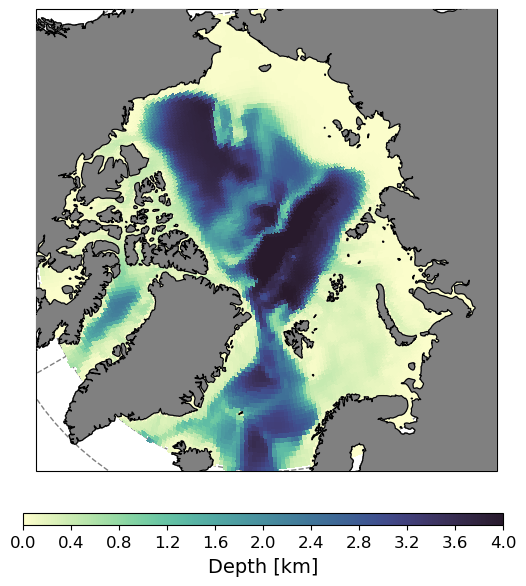

In [22]:
%%time

plt.figure(figsize=[12,6]);
f, ax, p, cbar, new_grid_lon_centers_out, new_grid_lat_centers_out,\
        data_latlon_projection_out, gl = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, 
                              ecco_grid.YC, 
                              -1*depth*1e-3, 
                              projection_type='stereo',
                              plot_type='pcolormesh',     
                              cmin=0, cmax=4,
                              cmap=cmocean.cm.deep,                                         
                              lat_lim=65,
                              user_lon_0=0, show_colorbar=False)


ax.coastlines()
ax.add_feature(land_50m, zorder=75) 

# Add a colorbar axis at the bottom of the graph
cbar_ax = f.add_axes([0.31, 0.02, 0.4, 0.02])

# Draw the colorbar
cbar=f.colorbar(p, cax=cbar_ax,orientation='horizontal', ticks=np.linspace(0,4,11))
cbar.set_label(r'Depth [km]', labelpad=5, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# plt.savefig('figs/kara_barents_arctic_domain.png', format='png', bbox_inches='tight', dpi=300)

### Performing weighted mean

In [23]:
weights = vol

In [24]:
tendH_ctrl_vol = ds['G_total'].weighted(weights.fillna(0)).mean(('tile','k','j','i'))
forcH_ctrl_vol = ds['G_forcing'].weighted(weights.fillna(0)).mean(('tile','k','j','i'))
advH_ctrl_vol = ds['G_advection'].weighted(weights.fillna(0)).mean(('tile','k','j','i'))
difH_ctrl_vol = ds['G_diffusion'].weighted(weights.fillna(0)).mean(('tile','k','j','i'))

total_ctrl_vol = (ds['G_forcing']+
                 ds['G_advection']+
                 ds['G_diffusion']).weighted(weights.fillna(0)).mean(('tile','k','j','i'))

In [25]:
tendH_ctrl_vol = tendH_ctrl_vol.compute()
forcH_ctrl_vol = forcH_ctrl_vol.compute()
advH_ctrl_vol = advH_ctrl_vol.compute()
difH_ctrl_vol = difH_ctrl_vol.compute()
total_ctrl_vol = total_ctrl_vol.compute()


/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 20.93 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 20.97 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0, 0.5, '  (10$^{-9}$ $\\circ$C s$^{-1}$)')

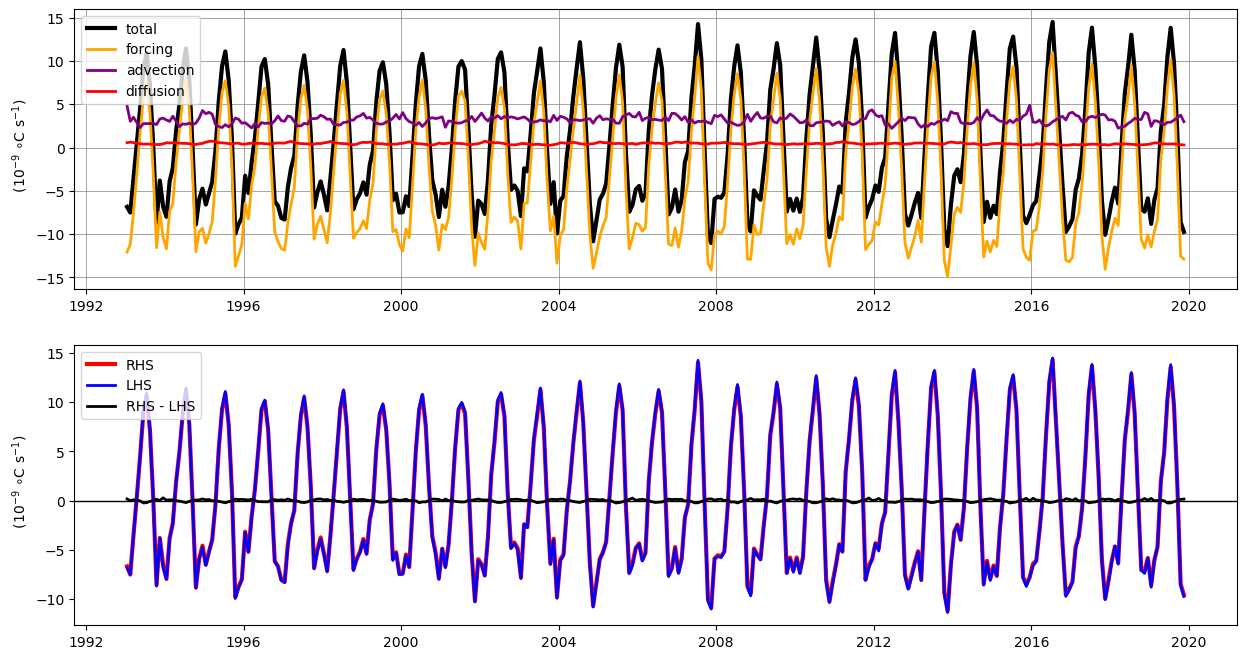

In [26]:
fig, axes = plt.subplots(2, 1,figsize=(15,8))

plt.subplot(2, 1, 1)

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(tendH_ctrl_vol.time, tendH_ctrl_vol*1e9, lw=3, color='black',label='total')
plt.plot(forcH_ctrl_vol.time, forcH_ctrl_vol*1e9, lw=2, color='orange',label='forcing')
plt.plot(advH_ctrl_vol.time, advH_ctrl_vol*1e9, lw=2, color='purple',label='advection')
plt.plot(difH_ctrl_vol.time, difH_ctrl_vol*1e9, lw=2, color='red',label='diffusion')
plt.legend()
#plt.ylim([-25, 25])
plt.ylabel(r'  (10$^{-9}$ $\circ$C s$^{-1}$)')

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(total_ctrl_vol.time, total_ctrl_vol*1e9, lw=3, color='red',label='RHS')
plt.plot(tendH_ctrl_vol.time, tendH_ctrl_vol*1e9, lw=2, color='blue',label='LHS')
plt.plot(tendH_ctrl_vol.time, (total_ctrl_vol-tendH_ctrl_vol)*1e9, lw=2, color='k',label='RHS - LHS')
plt.legend()
#plt.ylim([-25, 25])
plt.ylabel(r'  (10$^{-9}$ $\circ$C s$^{-1}$)')

# plt.savefig('figs/heat_budget_closure_fulldepth.png', format='png', bbox_inches='tight', dpi=300)

In [27]:
ds_tend_arctic_full = xr.merge([tendH_ctrl_vol.to_dataset(name='tnd'),
                                forcH_ctrl_vol.to_dataset(name='frc'),
                                advH_ctrl_vol.to_dataset(name='adv'),
                                difH_ctrl_vol.to_dataset(name='dif'),
                                total_ctrl_vol.to_dataset(name='tot')])

In [28]:
ds_tend_arctic_full.to_netcdf('data_files/tendencies_arctic_total_fulldepth.nc')

### Computing anomalies

In [29]:
# Seawater density (kg/m^3)
rhoconst = 1029
# Heat capacity (J/kg/K)
c_p = 3994

In [30]:
dt = ds.time.diff('time').astype('float32')
dt = dt/1e9

In [31]:
H_tnd = (tendH_ctrl_vol*dt).cumsum(dim='time')*rhoconst*c_p*vol.sum(dim=['tile','k','j','i'])
H_frc = (forcH_ctrl_vol*dt).cumsum(dim='time')*rhoconst*c_p*vol.sum(dim=['tile','k','j','i'])
H_adv = (advH_ctrl_vol*dt).cumsum(dim='time')*rhoconst*c_p*vol.sum(dim=['tile','k','j','i'])
H_dif = (difH_ctrl_vol*dt).cumsum(dim='time')*rhoconst*c_p*vol.sum(dim=['tile','k','j','i'])


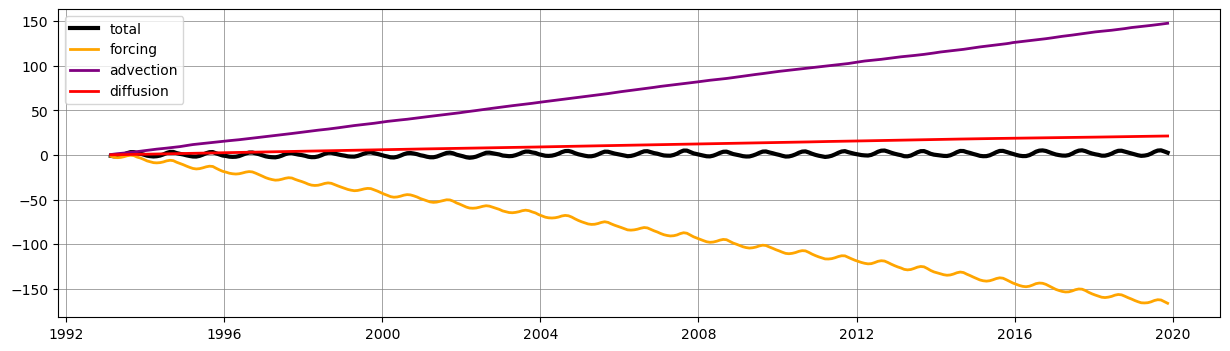

In [32]:
fig, axes = plt.subplots(figsize=(15,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(H_tnd.time, H_tnd*1e-23, lw=3, color='black',label='total')
plt.plot(H_frc.time, H_frc*1e-23, lw=2, color='orange',label='forcing')
plt.plot(H_adv.time, H_adv*1e-23, lw=2, color='purple',label='advection')
plt.plot(H_dif.time, H_dif*1e-23, lw=2, color='red',label='diffusion')
plt.legend()

### Detrending and creating anomalies

In [33]:
# Detrending code by Ryan Abernathy

def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

In [34]:
H_tnd_dtd = detrend(H_tnd, dims=['time'])
H_tnd_res = H_tnd_dtd.groupby('time.month') - H_tnd_dtd.groupby('time.month').mean('time')

H_frc_dtd = detrend(H_frc, dims=['time'])
H_frc_res = H_frc_dtd.groupby('time.month') - H_frc_dtd.groupby('time.month').mean('time')

H_adv_dtd = detrend(H_adv, dims=['time'])
H_adv_res = H_adv_dtd.groupby('time.month') - H_adv_dtd.groupby('time.month').mean('time')

H_dif_dtd = detrend(H_dif, dims=['time'])
H_dif_res = H_dif_dtd.groupby('time.month') - H_dif_dtd.groupby('time.month').mean('time')

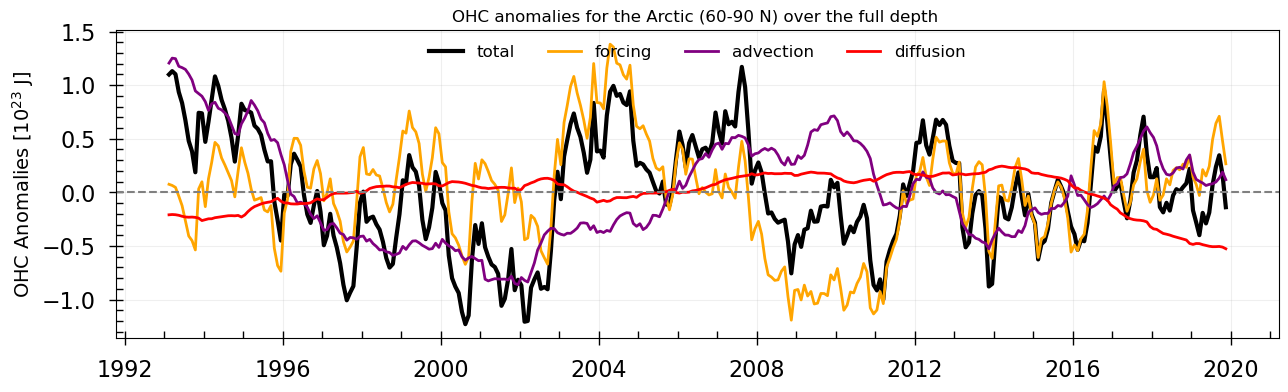

In [35]:
fig, ax = plt.subplots(figsize=(15,4))

# ax.grid(linestyle='-', linewidth='0.5', color='grey')
ax.plot(H_tnd.time, H_tnd_res*1e-23, lw=3, color='black',label='total')
ax.plot(H_frc.time, H_frc_res*1e-23, lw=2, color='orange',label='forcing')
ax.plot(H_adv.time, H_adv_res*1e-23, lw=2, color='purple',label='advection')
ax.plot(H_dif.time, H_dif_res*1e-23, lw=2, color='red',label='diffusion')

ax.set_ylabel('OHC Anomalies [$10^{23}$ J]', fontsize=14)
ax.set_title('OHC anomalies for the Arctic (60-90 N) over the full depth ')
ax.axhline(y=0, c='grey', linestyle='--')
ax.tick_params(which='both',
           labelcolor='k', 
           labelsize=16, 
           direction='inout',
           width=1,
           length=10,
           pad=10)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', direction='in', length=5, width=1, color='k')
ax.grid(alpha=0.2)
ax.legend(loc='upper center', ncol=4, frameon=False, fontsize=12)

# plt.savefig('figs/ohc_arctic_fulldepth.png', format='png', bbox_inches='tight', dpi=300)

In [36]:
ds_tend_arctic_full_anom = xr.merge([H_tnd_res.to_dataset(name='tnd'),
                                H_frc_res.to_dataset(name='frc'),
                                H_adv_res.to_dataset(name='adv'),
                                H_dif_res.to_dataset(name='dif')])

In [38]:
ds_tend_arctic_full_anom.to_netcdf('data_files/ohc_anom_arctic_total_fulldepth.nc')